In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import plotly as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from luciferml.supervised.classification import Classification
from luciferml.preprocessing import Preprocess as prep
from sklearn.metrics import accuracy_score
from matplotlib import pylab as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
import pickle

In [4]:
df = pd.read_excel(r'C:\Users\ASUS Zephyrus G15\DATA1030-Fall2021\data 1030 project\data\전국상수도수질검사표준데이터.xls')

In [5]:
y = df['Potability']
X = df.loc[:, df.columns != 'Potability']

In [6]:
std_ftrs = ['general_bacteria','lead','fluoride','arsenic','selenium','ammonia-like_nitrogen',
            'nitrogen_nitrate','cadmium','phenol','diazinone','carbaryl','1_1_1-trichloroethane','tetrachloroethylene','trichloroethylene',
            'carbon_tetrachloride','1_1-dichloroethylene','dichloromethane','toluene','Xylene','1_2-dibromo-3-chloropropane','1_4-dioxane.','residual_goat',
            'total_trihalomethane','chloroform','bromodichloromethane','chloral_hydrate','dibromoacetonitrile','dichloroacetonitrile','trichloroacetonitrile',
            'haloacetic_seed','formaldehyde','Bronze','chromaticity','detergent','pH','zinc','chloride_ion','Fe','Mn',
            'turbidity','sulfate_ion','potasium_permanganate_consumption','aluminum']

preprocessor = ColumnTransformer(transformers=[('std', StandardScaler(), std_ftrs)])

param_grid = {
              'randomforestclassifier__max_depth': [1, 3, 10, 25, 50], 
              'randomforestclassifier__max_features': [0.5,0.75,1.0] 
              } 

test_scores = np.zeros(5)
final_models = []

for i in range(5):
    X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=47*i)

    # splitter for other
    kf = KFold(n_splits=5,shuffle=True,random_state=47*i)
    
    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])
    
    # the classifier
    clf = RandomForestClassifier(random_state = 47*i) # initialize the classifier
    pipe = make_pipeline(preprocessor,clf)

    # use GridSearchCV
    # GridSearchCV loops through all parameter combinations and collects the results 
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'accuracy',
                        cv=kf, return_train_score = True, n_jobs=-1, verbose=True)
    
    # this line actually fits the model on other
    grid.fit(X_other, y_other)
    
    # save results into a data frame. feel free to print it and inspect it
    results = pd.DataFrame(grid.cv_results_)
    #print(results)

    print('best model parameters:',grid.best_params_)
    print('validation score:',grid.best_score_) # this is the mean validation score over all iterations
    # save the model
    final_models.append(grid)
    # calculate and save the test score
    y_test_pred = final_models[-1].predict(X_test)
    test_scores[i] = accuracy_score(y_test,y_test_pred)
    print('test score:',test_scores[i])
    print('test baseline = ',np.sum(y_test == 0)/len(y_test))
    print('test accuracy:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
    
    fname = r'C:\Users\ASUS Zephyrus G15\DATA1030-Fall2021\data 1030 project\results\RF'+str(i)+'.lasso'
    file = open(fname, 'wb')
    pickle.dump((grid,X_test,y_test),file)
    file.close()

Fitting 5 folds for each of 15 candidates, totalling 75 fits
best model parameters: {'randomforestclassifier__max_depth': 25, 'randomforestclassifier__max_features': 0.5}
validation score: 0.8654818310523831
test score: 0.8799019607843137
test baseline =  0.42892156862745096
test accuracy: 0.18 +/- 0.35
Fitting 5 folds for each of 15 candidates, totalling 75 fits
best model parameters: {'randomforestclassifier__max_depth': 25, 'randomforestclassifier__max_features': 0.75}
validation score: 0.8556488909863142
test score: 0.8578431372549019
test baseline =  0.4166666666666667
test accuracy: 0.35 +/- 0.43
Fitting 5 folds for each of 15 candidates, totalling 75 fits
best model parameters: {'randomforestclassifier__max_depth': 25, 'randomforestclassifier__max_features': 0.75}
validation score: 0.8538084001887682
test score: 0.9044117647058824
test baseline =  0.3799019607843137
test accuracy: 0.53 +/- 0.43
Fitting 5 folds for each of 15 candidates, totalling 75 fits
best model parameters: {

In [7]:
y_true = y_test
y_preds = y_preds = grid.predict(X_test)
                                         
print(confusion_matrix(y_true,y_preds))

[[128  27]
 [ 26 227]]


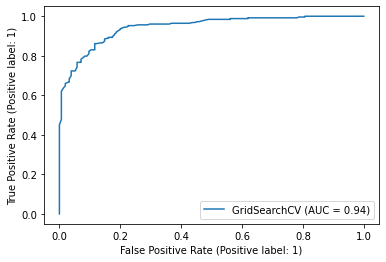

In [8]:
roc = plot_roc_curve(grid, X_test, y_test);

In [9]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = np.array(classes)
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

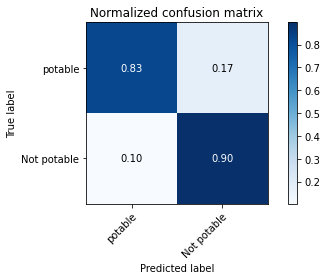

In [10]:
plot_confusion_matrix(y_true,y_preds,classes=['potable','Not potable'])
plt.tight_layout()
plt.savefig(r'C:\Users\ASUS Zephyrus G15\DATA1030-Fall2021\data 1030 project\figures\RF_Confusion_matrix',dpi = 300)
plt.show()

In [9]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       155
           1       0.89      0.90      0.90       253

    accuracy                           0.87       408
   macro avg       0.86      0.86      0.86       408
weighted avg       0.87      0.87      0.87       408



In [11]:
accuracy_scores =  {}


          
██╗░░░░░██╗░░░██╗░█████╗░██╗███████╗███████╗██████╗░░░░░░░███╗░░░███╗██╗░░░░░
██║░░░░░██║░░░██║██╔══██╗██║██╔════╝██╔════╝██╔══██╗░░░░░░████╗░████║██║░░░░░
██║░░░░░██║░░░██║██║░░╚═╝██║█████╗░░█████╗░░██████╔╝█████╗██╔████╔██║██║░░░░░
██║░░░░░██║░░░██║██║░░██╗██║██╔══╝░░██╔══╝░░██╔══██╗╚════╝██║╚██╔╝██║██║░░░░░
███████╗╚██████╔╝╚█████╔╝██║██║░░░░░███████╗██║░░██║░░░░░░██║░╚═╝░██║███████╗
╚══════╝░╚═════╝░░╚════╝░╚═╝╚═╝░░░░░╚══════╝╚═╝░░╚═╝░░░░░░╚═╝░░░░░╚═╝╚══════╝

Started LuciferML 

Checking if labels or features are categorical! [*]

Features are not categorical [ ✓ ]

Labels are not categorical [ ✓ ]

Checking for Categorical Variables Done [ ✓ ]

Checking for Sparse Matrix [*]

Checking for Sparse Matrix Done [ ✓ ]

Applying SMOTE [*]

SMOTE Done [ ✓ ]

Splitting Data into Train and Validation Sets [*]

Splitting Done [ ✓ ]

Scaling Training and Test Sets [*]

Scaling Done [ ✓ ]

Training Support Vector Machine on Training Set [*]

Model Training Done [ ✓ ]

Predicting 

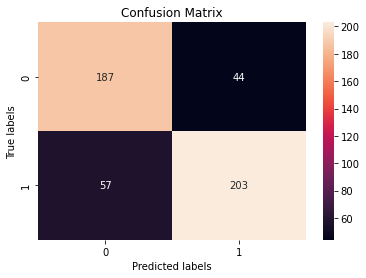

Confusion Matrix Done [ ✓ ]

Evaluating Model Performance [*]
Validation Accuracy is : 0.7942973523421588
Evaluating Model Performance [ ✓ ]

Applying K-Fold Cross Validation [*]
Accuracy: 75.17 %
Standard Deviation: 3.24 %
K-Fold Cross Validation [ ✓ ]

Complete [ ✓ ]

Time Elapsed :  2.0110538005828857 seconds 



In [83]:
params = {'C': .75, 'gamma': 0.2,
          'kernel': 'linear', 'random_state': 47}
classifier =  Classification(predictor = 'svm',params=params, smote = 'y')
classifier.fit(X, y)
result = classifier.result()
accuracy_scores[result['Classifier']] = result['Accuracy']

In [84]:
accuracy_scores

{'Support Vector Machine': 75.16549259297628}